<a href="https://colab.research.google.com/github/Siya-9/Homomorphic-Encryption/blob/main/Logistic_Regression_using_FHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 19.1 MB/s eta 0:00:00


In [2]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 0) Prepare data
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target

print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [4]:
data = pd.read_csv("bank.csv")
# drop rows with missing values
data = data.dropna()
data = data[:-5000]
# drop some features
data = data.drop(columns=["CustomerId", "Geography"])
y = data['Exited'].values
data = data.drop("Exited", 'columns')
X = data.values

print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-4-4484fb886e68>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop("Exited", 'columns')


In [5]:


n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=124)

# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

In [6]:
class LRModel(torch.nn.Module):
    def __init__(self, n_input_features):
        super(LRModel, self).__init__()
        self.linear = torch.nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = LRModel(n_features)

In [19]:
num_epochs = 300
learning_rate = 0.01
criterion = torch.nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optim.step()

    # zero grad before new step
    optim.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
        y_predicted = model(X_test)
        y_predicted_cls = y_predicted.round()
        acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
        print(f'accuracy: {acc.item():.4f}')


epoch: 10, loss = 0.4796
accuracy: 0.7767
epoch: 20, loss = 0.4781
accuracy: 0.7767
epoch: 30, loss = 0.4767
accuracy: 0.7767
epoch: 40, loss = 0.4754
accuracy: 0.7767
epoch: 50, loss = 0.4741
accuracy: 0.7767
epoch: 60, loss = 0.4728
accuracy: 0.7760
epoch: 70, loss = 0.4716
accuracy: 0.7760
epoch: 80, loss = 0.4704
accuracy: 0.7760
epoch: 90, loss = 0.4693
accuracy: 0.7760
epoch: 100, loss = 0.4682
accuracy: 0.7753
epoch: 110, loss = 0.4671
accuracy: 0.7753
epoch: 120, loss = 0.4661
accuracy: 0.7747
epoch: 130, loss = 0.4651
accuracy: 0.7733
epoch: 140, loss = 0.4641
accuracy: 0.7733
epoch: 150, loss = 0.4632
accuracy: 0.7733
epoch: 160, loss = 0.4623
accuracy: 0.7740
epoch: 170, loss = 0.4614
accuracy: 0.7740
epoch: 180, loss = 0.4606
accuracy: 0.7733
epoch: 190, loss = 0.4597
accuracy: 0.7733
epoch: 200, loss = 0.4589
accuracy: 0.7727
epoch: 210, loss = 0.4582
accuracy: 0.7733
epoch: 220, loss = 0.4574
accuracy: 0.7740
epoch: 230, loss = 0.4567
accuracy: 0.7747
epoch: 240, loss = 0

In [9]:
with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')

accuracy: 0.7773


In [10]:
class EncryptedLR:

    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_lr.linear.weight.data.tolist()[0]
        self.bias = torch_lr.linear.bias.data.tolist()

    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()


eelr = EncryptedLR(model)

In [11]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [12]:
t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in X_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 7 seconds


In [13]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()

    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        # encrypted evaluation
        enc_out = model(enc_x)
        # plain comparison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1

    t_end = time()
    print(f"Evaluated test_set of {len(X)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(X_test)} = {correct / len(X_test)}")
    return correct / len(X_test)


encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
print(encrypted_accuracy)
# diff_accuracy = plain_accuracy - encrypted_accuracy
# print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
# if diff_accuracy < 0:
#     print("Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...")

Evaluated test_set of 5000 entries in 16 seconds
Accuracy: 1160/1500 = 0.7733333333333333
0.7733333333333333


In [14]:
class EncryptedLR:

    def __init__(self, torch_lr):
        self.weight = torch_lr.linear.weight.data.tolist()[0]
        self.bias = torch_lr.linear.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.01
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [15]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [16]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in X_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 99 seconds


Distribution on plain data:


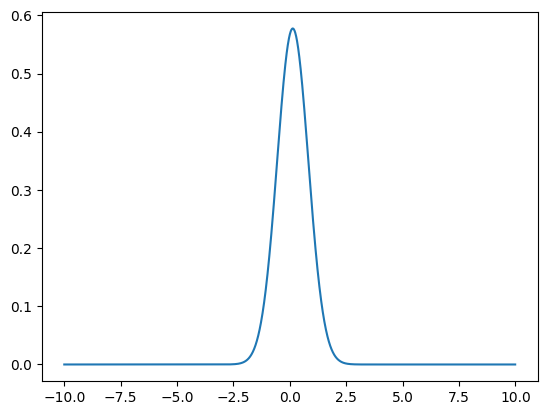

Distribution on encrypted data:


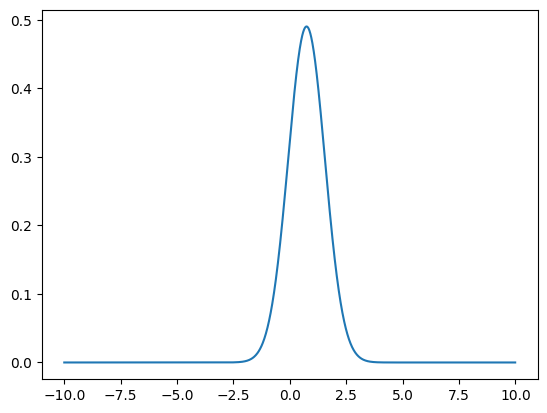

In [17]:
# normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

# def plot_normal_dist(mean, var, rmin=-10, rmax=10):
#     x = np.arange(rmin, rmax, 0.01)
#     y = normal_dist(x, mean, var)
#     fig = plt.plot(x, y)

# # plain distribution
# lr = LRModel(n_features)
# data = lr.linear(X_test)
# mean, var = map(float, [data.mean(), data.std() ** 2])
# plot_normal_dist(mean, var)
# print("Distribution on plain data:")
# plt.show()

# # encrypted distribution
# def encrypted_out_distribution(eelr, enc_x_test):
#     w = eelr.weight
#     b = eelr.bias
#     data = []
#     for enc_x in enc_x_test:
#         enc_out = enc_x.dot(w) + b
#         data.append(enc_out.decrypt())
#     data = torch.tensor(data)
#     mean, var = map(float, [data.mean(), data.std() ** 2])
#     plot_normal_dist(mean, var)
#     print("Distribution on encrypted data:")
#     plt.show()

# eelr = EncryptedLR(lr)
# eelr.encrypt(ctx_training)
# encrypted_out_distribution(eelr, enc_x_train)

In [18]:

eelr = EncryptedLR(LRModel(n_features))
accuracy = eelr.plain_accuracy(X_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(5):
    eelr.encrypt(ctx_training)

    # if you want to keep an eye on the distribution to make sure
    # the function approximation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)

    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)

    eelr.decrypt()
    accuracy = eelr.plain_accuracy(X_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")



Accuracy at epoch #0 is 0.5113333463668823
Accuracy at epoch #1 is 0.7866666913032532
Accuracy at epoch #2 is 0.7739999890327454
Accuracy at epoch #3 is 0.7706666588783264
Accuracy at epoch #4 is 0.7699999809265137
Accuracy at epoch #5 is 0.7713333368301392

Average time per epoch: 462 seconds
Final accuracy is 0.7713333368301392
Difference between plain and encrypted accuracies: 0.028666675090789795


In [23]:
plain_accuracy = 0.773

In [24]:
diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Difference between plain and encrypted accuracies: 0.0016666650772094727
